# LoFTR demo with custom image pairs on Colab
We provide an easier way to run LoFTR with a custom image pair without configuring a python environment with GPU support. Signing in your Google account is required to run this notebook in Colab.

Start by clicking Runtime --> Run all (Ctrl/Cmd + F9). 

Upload your own image pair with the "Choose Files" button to appear in the first cell. Please use horizontal images (width > height) and assign the image type (indoor/outdoor) accordingly.

You can also choose to use the example image pair provided in the LoFTR repo (from ScanNet) by using this cell (uncommenting the last line).


In [48]:
import torch
import cv2
import numpy as np
import matplotlib.cm as cm

from src.utils.plotting import make_matching_figure
from src.loftr import LoFTR, default_cfg

def get_matcher():
    image_type = 'outdoor'
    # The default config uses dual-softmax.
    # The outdoor and indoor models share the same config.
    # You can change the default values like thr and coarse_match_type.
    matcher = LoFTR(config=default_cfg)
    if image_type == 'indoor':
      matcher.load_state_dict(torch.load("weights/indoor_ds.ckpt")['state_dict'])
    elif image_type == 'outdoor':
      matcher.load_state_dict(torch.load("weights/outdoor_ds.ckpt")['state_dict'])
    else:
      raise ValueError("Wrong image_type is given.")
    return matcher.eval().cuda()
def predict_and_print(matcher,img0_raw,img1_raw):
    img0_raw = cv2.resize(img0_raw, (640, 480))
    img1_raw = cv2.resize(img1_raw, (640, 480))



    img0 = torch.from_numpy(img0_raw)[None][None].cuda() / 255.
    img1 = torch.from_numpy(img1_raw)[None][None].cuda() / 255.
    batch = {'image0': img0, 'image1': img1}
    # Inference with LoFTR and get prediction
    with torch.no_grad():
        matcher(batch)
        mkpts0 = batch['mkpts0_f'].cpu().numpy()
        mkpts1 = batch['mkpts1_f'].cpu().numpy()
        mconf = batch['mconf'].cpu().numpy()
    color = cm.jet(mconf, alpha=0.7)
    text = [
        'LoFTR',
        'Matches: {}'.format(len(mkpts0)),
    ]
    fig = make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text)

    # A high-res PDF will also be downloaded automatically.
    make_matching_figure(img0_raw, img1_raw, mkpts0, mkpts1, color, mkpts0, mkpts1, text, path="LoFTR-colab-demo.pdf")
    w_ave1 =np.expand_dims(np.average(mkpts1,axis=0,weights=mconf), 0)
    w_ave0 =np.expand_dims( np.average(mkpts0,axis=0,weights=mconf), 0)
    text = [
        'LoFTR',
        'Weighter_by_configence_mean: {}'.format(1),
    ]
    fig = make_matching_figure(img0_raw, img1_raw, w_ave0, w_ave1, color[0:1], w_ave0, w_ave1, text)
    # A high-res PDF will also be downloaded automatically.
    make_matching_figure(img0_raw, img1_raw, w_ave0, w_ave1, color[0:1], w_ave0, w_ave1, text, path="LoFTR-colab-demo.pdf")


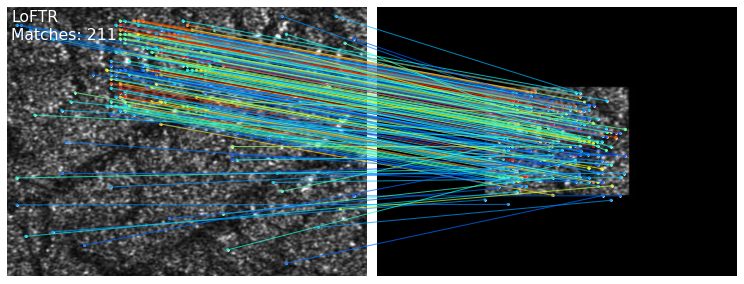

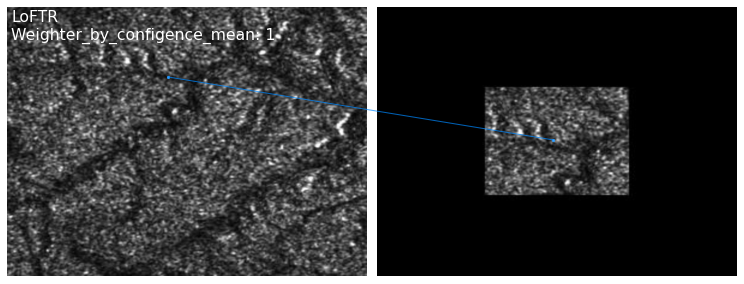

In [49]:
img0_pth = "./search_window.jpeg"
img1_pth = "./patch.jpeg"
image_pair = [img0_pth, img1_pth]
img0_raw = cv2.imread(image_pair[0], cv2.IMREAD_GRAYSCALE)
img1_raw = cv2.imread(image_pair[1], cv2.IMREAD_GRAYSCALE)
matcher=get_matcher()
predict_and_print(matcher,img0_raw,img1_raw)